In [3]:
import requests
import pandas as pd
import time
import json
import re
import yfinance as yf
import torch
import numpy as np
from transformers import pipeline
from datasets import Dataset
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from scipy.signal import savgol_filter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [33]:
NEWS_API_KEY = "8c000f53b56448cf98ceb1468d1c6cbd"
GDELT_URL = "https://api.gdeltproject.org/api/v2/doc/doc"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

# ---------------------- 1. NewsAPI ----------------------
def fetch_newsapi_news(query="bitcoin", page_size=20):
    url = f"https://newsapi.org/v2/everything?q={query}&pageSize={page_size}&apiKey={NEWS_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()["articles"]
    else:
        print(f"NewsAPI Request Failure: {response.status_code}")
        return []

# ---------------------- 2. GDELT ----------------------
def fetch_gdelt_news(start_date="20170101000000", end_date="20250301000000"):
    params = {
        "query": "(Bitcoin OR Cryptocurrency)",
        "mode": "ArtList",
        "format": "JSON",
        "maxrecords": 250,
        "sort": "DateDesc",
        "startdatetime": start_date,
        "enddatetime": end_date,
    }
    response = requests.get(GDELT_URL, params=params, headers=headers)
    clean_text = response.text.replace("\n", "").replace("\r", "").replace("\x00", "")
    if response.status_code == 200:
        data = json.loads(clean_text)
        return data.get("articles", [])
    else:
        print(f"GDELT Request Failure: {response.status_code}")
        return []

In [34]:
# ---------------------- 3. Get GDELT Historical News in Batches ----------------------
def fetch_gdelt_historical_news(start_year=2017, end_year=2025, interval_days=30):
    all_news = []
    start_date = datetime(start_year, 1, 1)
    while start_date.year < end_year:
        end_date = start_date + timedelta(days=interval_days)
        start_str = start_date.strftime("%Y%m%d%H%M%S")
        end_str = end_date.strftime("%Y%m%d%H%M%S")
        print(f"📡 Grab news from {start_str} to {end_str} ...")
        articles = fetch_gdelt_news(start_date=start_str, end_date=end_str)
        if articles:
            all_news.extend(articles)
        start_date = end_date
    return all_news

In [55]:
def convert_datetime(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str):
        return pd.NaT
    if "T" in date_str and len(date_str) == 16:
        return pd.to_datetime(date_str, format="%Y%m%dT%H%M%SZ", errors="coerce")
    elif "T" in date_str:
        return pd.to_datetime(date_str, format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")
    else:
        return pd.NaT
def clean_text(text):
    return re.sub(r"<.*?>", "", text)

In [36]:
# Get news from websites
newsapi_articles = fetch_newsapi_news()
gdelt_articles = fetch_gdelt_historical_news()

📡 Grab news from 20170101000000 to 20170131000000 ...
📡 Grab news from 20170131000000 to 20170302000000 ...
📡 Grab news from 20170302000000 to 20170401000000 ...
📡 Grab news from 20170401000000 to 20170501000000 ...
📡 Grab news from 20170501000000 to 20170531000000 ...
📡 Grab news from 20170531000000 to 20170630000000 ...
📡 Grab news from 20170630000000 to 20170730000000 ...
📡 Grab news from 20170730000000 to 20170829000000 ...
📡 Grab news from 20170829000000 to 20170928000000 ...
📡 Grab news from 20170928000000 to 20171028000000 ...
📡 Grab news from 20171028000000 to 20171127000000 ...
📡 Grab news from 20171127000000 to 20171227000000 ...
📡 Grab news from 20171227000000 to 20180126000000 ...
📡 Grab news from 20180126000000 to 20180225000000 ...
📡 Grab news from 20180225000000 to 20180327000000 ...
📡 Grab news from 20180327000000 to 20180426000000 ...
📡 Grab news from 20180426000000 to 20180526000000 ...
📡 Grab news from 20180526000000 to 20180625000000 ...
📡 Grab news from 20180625000

In [57]:
# Combine the data
all_news = []

for article in newsapi_articles:
    all_news.append({
        "source": "NewsAPI",
        "title": article.get("title", ""),
        "url": article.get("url", ""),
        "published_at": convert_datetime(article.get("publishedAt", ""))
    })

for article in gdelt_articles:
    all_news.append({
        "source": "GDELT",
        "title": article.get("title", ""),
        "url": article.get("url", ""),
        "published_at": convert_datetime(article.get("seendate", ""))
    })

df = pd.DataFrame(all_news)
df["published_at"] = df["published_at"].dt.strftime("%Y-%m-%d %H:%M:%S")
df.to_csv("./dataset/bitcoin_news.csv", index=False)
print(f"🎯 Totally grabed {len(all_news)} news!")

🎯 Totally grabed 24518 news!


In [ ]:
df = pd.read_csv("./dataset/bitcoin_news.csv")
df["title"] = df["title"].astype(str).apply(clean_text)
df = df.drop_duplicates(subset=["title"])
df = df.sort_values("published_at")

df.to_csv("./dataset/bitcoin_news_cleaned.csv", index=False)
print(f"✅ Clean finished! There's {len(df)} news left！")

In [15]:
device = 0 if torch.cuda.is_available() else -1
finbert = pipeline("text-classification", model="ProsusAI/finbert")
def batch_crypto_sentiment(batch):
    results = finbert(batch["title"], truncation=True)
    scores = []
    for result in results:
        if result["label"] == "positive":
            scores.append(result["score"])
        elif result["label"] == "negative":
            scores.append(-result["score"])
        else:
            scores.append(0)
    return {"sentiment": scores}

Device set to use cuda:0


In [17]:
df = pd.read_csv("./dataset/bitcoin_news_cleaned.csv")
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df = df.dropna(subset=["title"])

dataset = Dataset.from_pandas(df[["title"]])
dataset = dataset.map(batch_crypto_sentiment, batched=True, batch_size=16)
df["sentiment"] = dataset["sentiment"]

# Calculate sentiment coefficient in 10 day window
df.set_index("published_at", inplace=True)
df_resampled = df.resample("7D")["sentiment"].mean().reset_index()

# save the result
df_resampled.to_csv("./dataset/bitcoin_news_sentiment_finbert_10d.csv", index=False)

print("✅ Calculation finished!")

Map:   0%|          | 0/19655 [00:00<?, ? examples/s]

✅ Calculation finished!


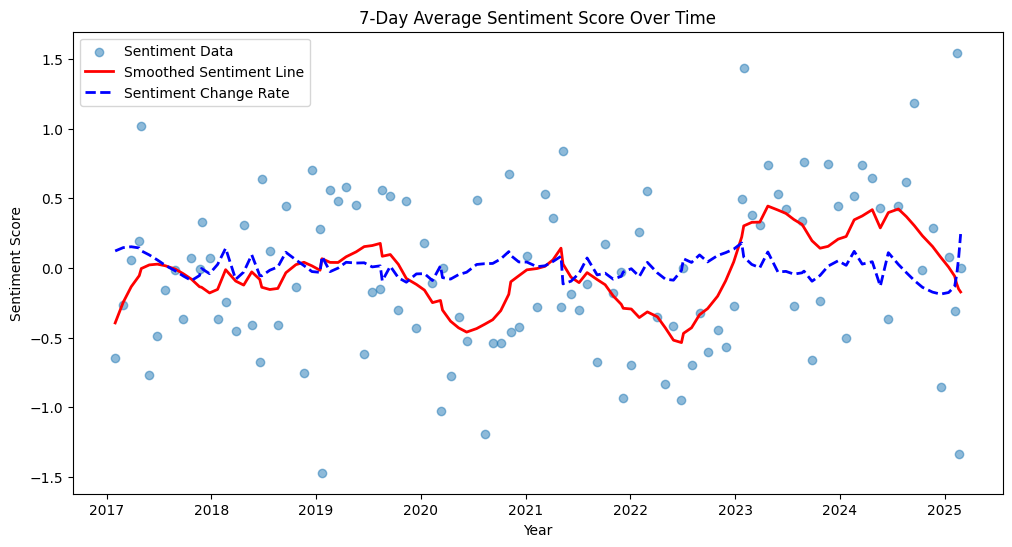

In [29]:
# load data
sentiment_7d = pd.read_csv("./dataset/bitcoin_news_sentiment_finbert_10d.csv")
sentiment_7d["published_at"] = pd.to_datetime(sentiment_7d["published_at"])
sentiment_7d = sentiment_7d.dropna(subset=['sentiment'])
sentiment_7d["sentiment"] = np.sign(sentiment_7d["sentiment"]) * np.log1p(np.abs(sentiment_7d["sentiment"]) * 10)

window_length = min(21, len(sentiment_7d["sentiment"]) - 1)
if window_length % 2 == 0:
    window_length -= 1
sentiment_7d["sentiment_diff"] = sentiment_7d["sentiment"].diff()

# plot line
smoothed_sentiment = savgol_filter(sentiment_7d["sentiment"], window_length=window_length, polyorder=3)
smoothed_diff = savgol_filter(sentiment_7d["sentiment_diff"].fillna(0), window_length=window_length, polyorder=3)

plt.figure(figsize=(12, 6))
plt.scatter(sentiment_7d["published_at"], sentiment_7d["sentiment"], marker="o", label="Sentiment Data", alpha=0.5)
plt.plot(sentiment_7d["published_at"], smoothed_sentiment, color="red", linewidth=2, label="Smoothed Sentiment Line")
plt.plot(sentiment_7d["published_at"], smoothed_diff, color="blue", linestyle="dashed", linewidth=2, label="Sentiment Change Rate")

years = sentiment_7d["published_at"].dt.year.unique()
plt.xticks([pd.Timestamp(str(year)) for year in years], years, rotation=0)
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.title("7-Day Average Sentiment Score Over Time")
plt.legend()
plt.show()